In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.util.infeasible import log_infeasible_constraints

from datetime import datetime
import pickle
import json
from sklearn.cluster import KMeans
import logging
pd.set_option('display.max_columns', None)  # or specify a number if you want a limit

# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.preprocessing import StandardScaler


In [2]:
# Basic Setting
grid = "369_0"
this_day = '2050-05-06'
this_weekday = 'Friday'
dateoffset = 3
next_two = False # True consider next 2 trips,False consider only next 1 trip
date = 6
scenario_year = 2050
day_start = pd.to_datetime(f"{scenario_year}-05-{date}")
day_end = pd.to_datetime(f"{scenario_year}-05-{date+1}")
path = f"{grid}/split_v5_{scenario_year}_{this_weekday}_1_0p5_test"
participate_rate = 1  # 1 no constraints on participation rate, parking event based, not vehicle based
min_power_level = 0.5 # 1 constant power request at max. charger power, otherwise set a lower limit on power requested: min_power_level * max_power

In [3]:
# Data Preprocessing
def create_dict(row):
    dict = [0]*24
    for hour in range(24):
        if (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day==date)&(row['arr_hour']<hour): 
            dict[hour] = 60
        elif (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day<date):
            dict[hour] = 60
        elif (row['park_end_day']>date) & (row['arr_time'].day==date)&(row['arr_hour']<hour): 
            dict[hour] = 60
        elif (row['park_end_day']>date) & (row['arr_time'].day<date):
            dict[hour] = 60
        elif (row['park_end_day']==date) & (row['park_end_hour']>hour) & (row['arr_time'].day==date)&(row['arr_hour']==hour): 
            dict[hour] = 60-row['arr_time'].minute
        elif  (row['park_end_day']>date) & (row['arr_hour']==hour)&(row['arr_time'].day==date):
            dict[hour] = 60-row['arr_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_hour']<hour) & (row['arr_time'].day==date):
            dict[hour] = row['park_end_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_time'].day<date):
            dict[hour] = row['park_end_time'].minute
        elif (row['park_end_hour']==hour) & (row['park_end_day']==date) & (row['arr_hour']==hour) & (row['arr_time'].day==date):
            dict[hour] = row['park_end_time'].minute-row['arr_time'].minute
        else:
            dict[hour]=0
    return dict

def soe_init(row):
    soe_init=[0]*24
    for hour in range(24):
        if row['arr_time'].day<date:
            soe_init[hour] = row['SoE_bc']
        elif (hour<=row["arr_hour"]) and (row['arr_time'].day==date):
            soe_init[hour]=row['SoE_bc']
        else:
            soe_init[hour]=0
    return soe_init

def create_charge_time_list(row):
    charge_time_list = [0]*24
    if row['c']:
        st_chg = row['st_chg_time'].hour
        ed_chg = row['ed_chg_time'].hour
        for t in range(24):
            if (st_chg==t) & (ed_chg==t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = row['ed_chg_time'].minute-row['st_chg_time'].minute
            elif (st_chg<t) & (ed_chg>t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = 60
            elif (st_chg<t) & (ed_chg==t) & (row['ed_chg_time'].day == date):
                charge_time_list[t] = row['ed_chg_time'].minute
            elif (st_chg==t) & (((ed_chg>t) & (row['ed_chg_time'].day == date))|(row['ed_chg_time'].day>date)):
                charge_time_list[t] = 60-row['st_chg_time'].minute
            elif (st_chg<t) & (row['ed_chg_time'].day>date):
                charge_time_list[t]=60
            else:
                charge_time_list[t]=0
    return charge_time_list

# Data Postprocessing
def get_timestamp_pair(row):
    process = {}
    process_key = ()
    power = []
    for hour in range(24):
        p_t = row['optimized_power_list'][hour]
        min_t = row['hourly_time_dict'][hour]
        if hour>0:
            min_pre, p_pre = row['hourly_time_dict'][hour-1],row['optimized_power_list'][hour-1]
        else: 
            min_pre,p_pre = 0,0
        if hour<23:
            min_next, p_next = row['hourly_time_dict'][hour+1],row['optimized_power_list'][hour+1]
        else:
            min_next, p_next = 0,0
        if p_pre==0 and p_t!=0:
            if (min_t == 60 or min_pre==60) and (hour!=row['arr_time'].hour):
                start_min = 0
            elif (min_t<60 and min_pre!=60 and min_t>0) and (hour!=row['arr_time'].hour):
                start_min = 60-min_t
            elif (hour==row['arr_time'].hour):
                start_min = row['arr_time'].minute
            else:
                start_min = 0
            start_ts = pd.Timestamp(datetime(year=scenario_year,month=5,day=date,hour=hour,minute=start_min))
            process_key = (start_ts,)
        if p_t!=0:
            power.append(p_t)
        if p_next==0 and p_t!=0:
            if (min_t==60 or min_next>0) and (hour!=row['park_end_time'].hour):
                end_min=59
            elif (min_t<60 and min_next==0 and min_pre>0) and (hour!=row['park_end_time'].hour):
                end_min=min_t
            elif (hour==row['park_end_time'].hour):
                end_min=row['park_end_time'].minute
            else:
                end_min = 0
            end_ts = pd.Timestamp(datetime(year=scenario_year,month=5,day=date,hour=hour,minute=end_min))
            process_key = process_key + (end_ts,)
            process[process_key] = power
            process_key = ()
            power = []
    return process

def calculate_next_trip_e(row):
    if next_two and (row['next_parking_time']<60):
        next_trip_e = row['next_travel_TP1_consumption']+row['next_2_travel_TP1_consumption']
    else:
        next_trip_e =  row['next_travel_TP1_consumption']
    return next_trip_e
        

In [103]:
df = pd.read_csv(f"{grid}/grid369_mobility_dataset.csv")

df['dep_time'] = pd.to_datetime(df['dep_time'],format='mixed')
df['arr_time'] = pd.to_datetime(df['arr_time'],format='mixed')
df['st_chg_time'] = pd.to_datetime(df['st_chg_time'],format='mixed')
df['ed_chg_time'] = pd.to_datetime(df['ed_chg_time'],format='mixed')
df['chg_time'] = pd.to_timedelta(df['ed_chg_time']-df['st_chg_time'],unit='m')

df['dep_time'] = df['dep_time'] + pd.DateOffset(days=dateoffset)
df['dep_time'] = df.apply(lambda row:row['dep_time'].replace(year=scenario_year), axis=1)
df['arr_time'] = df['dep_time'] + pd.to_timedelta(df['trav_time'], unit='m')
df['arr_hour'] = df['arr_time'].dt.hour
df['dep_hour'] = df['dep_time'].dt.hour
df['arr_type_day'] = df['arr_time'].dt.dayofweek

df['park_end_time'] = df['arr_time']+pd.to_timedelta(df['parking_time'],unit='m')
df['park_end_hour'] = df['park_end_time'].dt.hour
df['park_end_day'] = df['park_end_time'].dt.day

df.sort_values(by=['person','dep_time'])
df['next_travel_TP1_consumption'] = df.groupby('person')['TP1 consumption kWh'].shift(-1).fillna(0)
df['next_parking_time'] = df.groupby('person')['parking_time'].shift(-1).fillna(0)
df['next_2_travel_TP1_consumption'] = df.groupby('person')['TP1 consumption kWh'].shift(-2).fillna(0)
df['next_trip_e'] = df.apply(calculate_next_trip_e,axis=1)

df.drop(['next_parking_time', 'next_travel_TP1_consumption', 'next_2_travel_TP1_consumption', 'TP1 rate kWh/100 km',
         'TP2 rate kWh/100 km', 'TP2 consumption kWh',
         'TP3 rate kWh/100 km', 'TP3 consumption kWh', 'TP4 rate kWh/100 km',
         'TP4 consumption kWh', 'st_mun_name', 'st_canton_name', 'st_urb_type',
         'st_mnt_type', 'ed_mun_name', 'ed_canton_name', 'ed_urb_type',
         'ed_mnt_type', 'Yearly kWh'], axis=1, inplace=True)

# d = df[(df['grid'] == "369_0") & ((df['arr_type_day'] == 3) | (df['arr_type_day'] == 4))]
d = df[(df['arr_type_day'] == 3) | (df['arr_type_day'] == 4)]
d['st_chg_time'] = d['st_chg_time']+pd.DateOffset(days=dateoffset)
d['st_chg_time'] = d.apply(lambda row:row['st_chg_time'].replace(year=scenario_year), axis=1)
d['ed_chg_time'] = d['st_chg_time']+d['chg_time']
d['chg_time'] = d['chg_time'].dt.total_seconds()/60
d = d[(d['park_end_time']>=day_start) & (d['arr_time']<day_end)]

d.insert(0,'event_index',d.index)

d['max_chg_e'] = d['B']-d['SoE_bc']
d['real_chg_e'] = d['SoE_ac']-d['SoE_bc']
d['hourly_time_dict'] = d.apply(lambda x:create_dict(x), axis =1)
d['soe_init'] = d.apply(lambda x:soe_init(x), axis =1)
d['charge_time_list'] = d.apply(lambda x:create_charge_time_list(x), axis=1)
d['charge_power_list'] = d.apply(lambda x: [x['chg rate'] if t >30 else 0 for t in x['charge_time_list']], axis=1)
d['charge_energy_list'] = d.apply(lambda x:[t/60*x['chg rate']for t in x['charge_time_list']], axis=1)
d.to_pickle(f'{path}/grid_{grid}_{scenario_year}_{this_weekday}_preprocessed_1trip.pkl')
# d.head(200)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_10096/4069686985.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['st_chg_time'] = d['st_chg_time']+pd.DateOffset(days=dateoffset)
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_10096/4069686985.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['st_chg_time'] = d.apply(lambda row:row['st_chg_time'].replace(year=scenario_year), axis=1)
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_10096/4069686985.py:37: SettingWit

In [4]:
with open(f'/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/369_0/split_v5_2050_Friday_1_0p5/grid_369_0_2050_Friday_preprocessed.pkl', 'rb') as d:
    d = pickle.load(d)

In [11]:
# Step 1: Calculate aggregates for arr_hour and dep_hour for each person_id
times = d.groupby('person').agg({
    'arr_hour': ['min', 'max'],
    'dep_hour': ['min', 'max']
}).reset_index()
# Flatten the MultiIndex for columns created by aggregation
times.columns = ['_'.join(col).strip('_') for col in times.columns.values]
# Create a feature dataframe for clustering
feature_df = times[['arr_hour_min', 'arr_hour_max', 'dep_hour_min', 'dep_hour_max']]
# Step 2: Cluster based on behavior
kmeans = KMeans(n_clusters=30, random_state=42).fit(feature_df)
times['cluster'] = kmeans.labels_
# Assign cluster labels to each person
clustered = pd.merge(d, times[['person', 'cluster']], on='person')
clustered = clustered.sort_values(by=['person','dep_time','cluster'])
# Get unique persons and the start index for each person
unique_persons = clustered['person'].unique()
person_start_index = {person: i for i, person in enumerate(unique_persons)}
# Calculate the number of groups
num_groups = 30
# Create a dictionary to hold the group number for each person
person_to_group = {}
# Assign groups in a round-robin fashion
group_number = 1
for person in unique_persons:
    person_to_group[person] = group_number
    group_number = group_number % num_groups + 1  # Loop back to 1 after reaching num_groups
# Now assign the group to each row in the DataFrame based on the 'person' column
clustered['group'] = clustered['person'].map(person_to_group)
clustered.drop(['cluster'],axis=1,inplace=True)
# Create a mask for your condition
condition_mask = (clustered['st_chg_time'] != clustered['ed_chg_time']) & (clustered['st_chg_time'] < day_start)

# Calculate the 'SoE_change' based on the condition
clustered['SoE_change'] = clustered.groupby(['group', 'person', 'grid'])['SoE_ac'].shift(1)

# Apply the condition to decide which fallback to use for .fillna()
clustered['pre_ed_chg_time'] = clustered.groupby(['group', 'person', 'grid'])['st_chg_time'].shift(1)
clustered['pre_c'] = clustered.groupby(['group', 'person', 'grid'])['c'].shift(1).fillna(False)
clustered['shifted_SoE_ac'] = clustered.groupby(['group', 'person', 'grid'])['SoE_ac'].shift(1).fillna(clustered['SoE_bc'])
clustered['shifted_SoE_bc'] = clustered.groupby(['group', 'person', 'grid'])['SoE_bc'].shift(1).fillna(clustered['SoE_bc'])
# Initialize 'SoE_change' column
clustered['SoE_change'] = np.where(
    (clustered['pre_c']) & (clustered['pre_ed_chg_time']>day_start),
    clustered['shifted_SoE_bc']-clustered['SoE_bc'],
    clustered['shifted_SoE_ac']-clustered['SoE_bc']
)
clustered.drop(['shifted_SoE_ac','shifted_SoE_bc','pre_ed_chg_time','pre_c'],axis=1)
# clustered['SoE_change'] = clustered.groupby(['group','person','grid'])['SoE_bc'].shift(1).fillna(clustered['SoE_bc'])-clustered['SoE_bc']
clustered.set_index('event_index', inplace=True)
clustered.head(100)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/4070289629.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clustered['pre_c'] = clustered.groupby(['group', 'person', 'grid'])['c'].shift(1).fillna(False)


,person,dep_time,trav_time,traveled_distance,start_activity_type,end_activity_type,start_x,start_y,end_x,end_y,arr_time,parking_time,TP1 consumption kWh,id_node,name_node,type_day,B,chg rate,SoE_bc,soe_if,c,SoE_ac,st_chg_time,ed_chg_time,grid,chg_time,arr_hour,dep_hour,arr_type_day,park_end_time,park_end_hour,park_end_day,next_trip_e,max_chg_e,real_chg_e,hourly_time_dict,soe_init,charge_time_list,charge_power_list,charge_energy_list,group,SoE_change,pre_ed_chg_time,pre_c,shifted_SoE_ac,shifted_SoE_bc
event_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,2630,2050-05-05 22:36:12,86.950000,105.963,leisure,home,2690730.0,1265350.0,2661738.0,1191299.0,2050-05-06 00:03:09.000000000,873.050000,33.922763,70.0,CH_Giswil_220,Thursday,90.0,7.0,56.08,NaN,True,90.00,2050-05-06 00:03:09.000000000,2050-05-06 04:53:53.571428580,NaN,290.742857,0,22,4,2050-05-06 14:36:12.000000000,14,6,33.893590,33.92,33.92,"[57, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 6...","[56.08, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[57, 60, 60, 60, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[7.0, 7.0, 7.0, 7.0, 7.0, 0, 0, 0, 0, 0, 0, 0,...","[6.6499999999999995, 7.0, 7.0, 7.0, 6.18333333...",1,0.00,NaT,False,56.08,56.08
8,2630,2050-05-06 14:36:12,87.866667,113.636,home,leisure,2661738.0,1191299.0,2690730.0,1265350.0,2050-05-06 16:04:04.000000002,392.133333,33.893590,89.0,CH_Riet_220,Friday,90.0,22.0,56.11,NaN,True,90.00,2050-05-06 16:04:04.000000020,2050-05-06 17:36:29.636363640,NaN,92.427273,16,14,4,2050-05-06 22:36:11.999999982,22,6,33.922763,33.89,33.89,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[56.11, 56.11, 56.11, 56.11, 56.11, 56.11, 56....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.00,NaT,False,56.11,56.11
33,5264,2050-05-05 21:13:36,95.183333,124.102,leisure,home,2687860.0,1267972.0,2655938.0,1187639.0,2050-05-05 22:48:46.999999998,624.816667,37.971099,70.0,CH_Giswil_220,Thursday,120.0,7.0,81.38,NaN,False,81.38,2050-05-05 22:48:46.999999980,2050-05-05 22:48:46.999999980,NaN,0.000000,22,21,3,2050-05-06 09:13:36.000000018,9,6,32.680730,38.62,0.00,"[60, 60, 60, 60, 60, 60, 60, 60, 60, 13, 0, 0,...","[81.38, 81.38, 81.38, 81.38, 81.38, 81.38, 81....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.00,NaT,False,81.38,81.38
34,5264,2050-05-06 09:13:36,72.716667,102.584,home,work,2655938.0,1187639.0,2656034.0,1248571.0,2050-05-06 10:26:19.000000002,2.283333,32.445072,64.0,CH_Birr_220,Friday,120.0,11.0,48.93,NaN,False,48.93,2050-05-06 10:26:19.000000020,2050-05-06 10:26:19.000000020,NaN,0.000000,10,9,4,2050-05-06 10:28:35.999999982,10,6,0.235658,71.07,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...","[48.93, 48.93, 48.93, 48.93, 48.93, 48.93, 48....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.00,NaT,False,48.93,48.93
35,5264,2050-05-06 10:28:36,2.183333,0.869,work,leisure,2656034.0,1248571.0,2655476.0,1248207.0,2050-05-06 10:30:46.999999998,72.816667,0.235658,59.0,CH_Rupperswil_220,Friday,120.0,22.0,48.69,NaN,True,75.39,2050-05-06 10:30:46.999999980,2050-05-06 11:43:36.090909060,NaN,72.818182,10,10,4,2050-05-06 11:43:36.000000018,11,6,19.596804,71.31,26.70,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 43, 0, 0, 0...","[48.69, 48.69, 48.69, 48.69, 48.69, 48.69, 48....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 43, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22.0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.00,NaT,False,48.69,48.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,132589,2050-05-06 17:57:35,8.350000,4.191,work,shop,2698392.0,1265630.0,2697212.0

In [6]:
# Normalize Tobia's Nexus Output
hv_bus = str(89)
# Controlled charging
charge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/Added_up_charge_{scenario_year}_raw.csv") # in MW
charge['ts'] = pd.to_datetime(charge['ts'])
charge = charge.loc[(charge.ts<day_end) & (charge.ts>=day_start)][['ts','peak',hv_bus]]
# Controlled discharging
discharge = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/extracted_data/map_bus/EVBatt_power_hourly_{scenario_year}_discharge_mapped.csv")
discharge = discharge.rename(columns={'Unnamed: 0':'ts'})
discharge['ts'] = pd.to_datetime(discharge['ts'])
discharge = discharge.loc[(discharge.ts<day_end) & (discharge.ts>=day_start)][['ts',hv_bus]]
# Find Netload Max
net= charge['89']-discharge['89']
day_max = net.max()
charge['normalized_profile'] = charge[hv_bus]/day_max
charge.index=range(24)
discharge['normalized_profile'] = discharge[hv_bus]/day_max
discharge.index=range(24)
net = charge['89']-discharge['89']
net_normalized = net/day_max

In [45]:
def opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,date,cluster_i,path):
    t_list = list(range(24))
    e_list = list(cluster.index)
    p_list= list(cluster['person'].unique())
    tomatch_c = charge['normalized_profile']
    tomatch_d = discharge['normalized_profile']
    tomatch_net = net_normalized
    event_cnt = len(cluster)
    
    m = ConcreteModel()
    ############################
    # Set
    m.E = Set(initialize=e_list) # parking event_index
    m.T = Set(initialize=t_list) # hour of the day
    m.P = Set(initialize=p_list) # list of person
    ############################
    # Decision Variable
    m.charge_power = Var(m.E, m.T,within=NonNegativeReals,bounds=(0,1.5),initialize=0) 
    m.discharge_power = Var(m.E,m.T,within=NonNegativeReals,bounds=(0,1),initialize=0)
    
    m.is_parked = Var(m.E, m.T, within=Binary)
    m.is_charging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_discharging = Var(m.E,m.T,within=Binary,initialize=0)
    m.is_active = Var(m.E,within=Binary,initialize=0)
    m.charge_jump = Var(m.E,m.T, within=Binary,initialize=0) # detect charge jump
    m.discharge_jump = Var(m.E,m.T, within=Binary,initialize=0) # detect discharge jump

    
    # Slack Variable
    m.charge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals,initialize=0)
    m.discharge_power_limit_s = Var(m.E, m.T, within=NonNegativeReals, initialize=0)
    m.energy_surplus = Var(within=NonNegativeReals)#bounds=(0,0.3*normalized_tot_e)
    m.energy_deficit = Var(within=NonNegativeReals)#bounds=(0,0.3*normalized_tot_e)
    m.ev_nonnegative_slack = Var(m.P,m.T,within=NonNegativeReals)
    m.next_trip_slack = Var(m.P,m.T,within=NonNegativeReals,bounds=(0,120/emob_max_p),initialize=120/emob_max_p)
    
    # Auxiliary Variable
    m.tot_charge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    m.tot_discharge_z = Var(m.T, within=NonNegativeReals, initialize=0)
    ###########################
    # Parameters
    m.event_cnt = Param(initialize=event_cnt)
    
    person_id = {e:cluster.loc[e,'person'] for e in e_list}
    m.person_id = Param(m.E, initialize=person_id) # the person_id of that event

    first_SoE_bc_list = cluster.groupby('person')['start_SoE'].first()
    ev_soe = {p:first_SoE_bc_list[p]/emob_max_p for p in p_list}
    m.ev_soe = Param(m.P, initialize=ev_soe, within=NonNegativeReals)
    
    load_c = {t:tomatch_c[t] for t in t_list}
    m.charge_to_match = Param(m.T,initialize=load_c) # Normalized nexus profile
    
    load_d = {t:tomatch_d[t] for t in t_list}
    m.discharge_to_match = Param(m.T,initialize=load_d) # Normalized nexus profile
    
    load_net = {t:tomatch_net[t] for t in t_list}
    m.netload_to_match = Param(m.T,initialize=load_net) # Normalized net charge nexus profile
    
    capacity_list = cluster.groupby('person')['B'].first()
    capacity_e = {e:cluster.loc[e,'B']/emob_max_p for e in e_list}
    m.capacity_e = Param(m.E,initialize=capacity_e) # Normalized battery capacity
    capacity_p = {p:capacity_list[p]/emob_max_p for p in p_list}
    m.capacity_p = Param(m.P, initialize=capacity_p)
    
    max_power_dict = {e:cluster.loc[e,'normalized_chg_power'] for e in e_list} # max charge rate at normalized scale
    m.max_power = Param(m.E,initialize=max_power_dict) # unit kW

    parking_duration = {e:cluster.loc[e,'parking_time'] for e in e_list}
    m.parking_durat = Param(m.E,initialize=parking_duration) # parking time in minutes
    
    parking_time_dict = {(e,t):cluster.loc[e,'hourly_time_dict'][t]/60 if cluster.loc[e,'hourly_time_dict'][t]>1 else 0 for e in e_list for t in t_list}
    m.parking_time = Param(m.E,m.T,initialize=parking_time_dict,within=NonNegativeReals) # parking minutes within this hour
    next_trip_e_dict = {e:cluster.loc[e,'next_trip_e']/emob_max_p for e in e_list}
    m.next_trip_e = Param(m.E,initialize=next_trip_e_dict) # normalized energy next trip requires
    
    park_end_hour_dict = {e:cluster.loc[e,'park_end_hour'] for e in e_list}
    m.park_end_hour = Param(m.E,initialize=park_end_hour_dict) # Park End Hour
    
    park_end_day = {e:cluster.loc[e,'park_end_day'] for e in e_list}
    m.park_end_day = Param(m.E, initialize=park_end_day)# Park End Day
    
    arr_day = {e:cluster.loc[e,'arr_time'].day for e in e_list}
    m.arr_day = Param(m.E,initialize=arr_day)
    
    arr_hour = {e:cluster.loc[e,'arr_hour'] for e in e_list}
    m.arr_hour = Param(m.E, initialize=arr_hour)
    
    SoE_change = {e:cluster.loc[e,'SoE_change']/emob_max_p for e in e_list}
    m.SoE_change = Param(m.E, initialize=SoE_change)
    
    SoE_dict = {(e,t):cluster.loc[e,'soe_init'][t]/emob_max_p for e in e_list for t in t_list}
    m.SoE_2d = Param(m.E,m.T,initialize=SoE_dict) # initial SoE profile
    
    SoE_init= {e:cluster.loc[e,'SoE_bc']/emob_max_p for e in e_list}
    m.SoE_init = Param(m.E,initialize=SoE_init) # initial SoE profile
    
    max_chg_e_dict = {e:cluster.loc[e,'max_chg_e']/emob_max_p for e in e_list}
    m.max_chg_e = Param(m.E,initialize=max_chg_e_dict) # max energy to charge for each event 
    
    m.unshifted_daily_energy = Param(initialize=normalized_tot_e)
    
    charge_status_change = {e:0 for e in e_list}
    m.charge_status_change = Param(m.E, initialize=charge_status_change) 
    
    ############################
    # enforce is_charging=1 if charging, 0 if discharging/no action
    def positive_charge_power_rule_1(m, e, t):
        return m.charge_power[e, t] <= 1000000 * m.is_charging[e, t]
    m.positive_charge_power_con = Constraint(m.E, m.T, rule=positive_charge_power_rule_1)

    # enforce is_discharging=1 if discharging, 0 if charging/no action
    def negative_charge_power_rule(m, e, t):
        return m.discharge_power[e, t] <= 1000000 * m.is_discharging[e, t]
    m.negative_charge_power_con = Constraint(m.E, m.T, rule=negative_charge_power_rule)
    # avoid simultaneous charge and discharge
    def non_simultaneous_rule(m, e, t):
        return m.is_charging[e, t] + m.is_discharging[e, t] <= 1
    m.non_simultaneous_con = Constraint(m.E, m.T, rule=non_simultaneous_rule)
    # enforce is_parked=1 if parking and ready to participate in grid, 0 if not available
    def parking_logic_constraint(m, e, t):
        M = 1000000  # Big M value, adjust as necessary
        return m.parking_time[e, t] <= M * m.is_parked[e, t]
    m.parking_logic = Constraint(m.E, m.T, rule=parking_logic_constraint)

    '''
    charging power limit
    '''
    # charge/discharge power slightly deviate from max charge power
    def charge_power_limit_rule(m,e,t):
        return  m.charge_power[e, t]  <= m.max_power[e] * m.is_charging[e,t] # + m.charge_power_limit_s[e,t]
    m.power_limit_c = Constraint(m.E, m.T, rule=charge_power_limit_rule)
    def discharge_power_limit_rule(m,e,t):
        return  m.discharge_power[e, t] <= m.max_power[e] * m.is_discharging[e,t] # + m.discharge_power_limit_s[e,t]
    m.power_limit_d = Constraint(m.E, m.T, rule=discharge_power_limit_rule)
    
    def charge_power_limit_s_upper_rule(m, e, t):
        return m.charge_power[e, t] >= min_power_level * m.max_power[e]*m.is_charging[e,t]
    m.charge_power_limit_s_upper = Constraint(m.E, m.T, rule=charge_power_limit_s_upper_rule)

    def discharge_power_limit_s_upper_rule(m, e, t):
        return m.discharge_power[e, t] >= min_power_level * m.max_power[e]*m.is_discharging[e,t]
    m.discharge_power_limit_s_upper = Constraint(m.E, m.T, rule=discharge_power_limit_s_upper_rule)
    
    def decreasing_charge_rule(m,e,t):
        if  m.arr_day[e]==date and t>=m.arr_hour[e] and t<23:
            return (m.charge_power[e,t]-m.charge_power[e,t+1])*m.is_charging[e,t]>=0
        elif m.arr_day[e]<date and t<23:
            return (m.charge_power[e,t]-m.charge_power[e,t+1])*m.is_charging[e,t]>=0
        else:
            return Constraint.Skip
    m.decreasing_charge = Constraint(m.E,m.T,rule=decreasing_charge_rule)
    def decreasing_discharge_rule(m,e,t):
        if m.arr_day[e]==date and t>=m.arr_hour[e] and t<23:
            return (m.discharge_power[e,t]-m.discharge_power[e,t+1])*m.is_discharging[e,t]>=0
        elif m.arr_day[e]<date and t<23:
            return (m.discharge_power[e,t]-m.discharge_power[e,t+1])*m.is_discharging[e,t]>=0
        else:
            return Constraint.Skip
    m.decreasing_discharge = Constraint(m.E,m.T,rule=decreasing_discharge_rule)
    
    def parking_rule_c(m,e,t):
        if m.parking_time[e,t]==0: 
            return m.charge_power[e,t]==0 # not parked for charge
        elif t<23 and m.parking_time[e,t]<float(0.25/3) and m.parking_time[e,t+1]==0:
            return m.charge_power[e,t]==0 # do not charge in the last parking hour less than 5 min
        else:
            return Constraint.Skip
    m.parking_c = Constraint(m.E,m.T,rule=parking_rule_c)   
    def parking_rule_d(m,e,t):
        if m.parking_time[e,t]==0:
            return m.discharge_power[e,t]==0 # not parked for discharge
        else:
            return Constraint.Skip
    m.parking_d = Constraint(m.E,m.T,rule=parking_rule_d)  
    
    # Plug in as soon as parked
    # def charge_immediate_rule(m,e,t):
    #     if (t>m.arr_hour[e]) and (m.arr_day[e] == date) and t>0:
    #         return m.is_charging[e,t-1]>=m.is_charging[e,t]
    #     elif m.arr_day[e]<date and t>0:
    #         return m.is_charging[e,t-1]>=m.is_charging[e,t]
    #     else:
    #         return Constraint.Skip
    # m.charge_immediate = Constraint(m.E,m.T,rule=charge_immediate_rule)
    # 
    # def discharge_immediate_rule(m,e,t):
    #     if (t>m.arr_hour[e]) and (m.arr_day[e] == date) and t>0:
    #         return m.is_discharging[e,t-1]>=m.is_discharging[e,t]
    #     elif m.arr_day[e]<date and t>0:
    #         return m.is_discharging[e,t-1]>=m.is_discharging[e,t]
    #     else:
    #         return Constraint.Skip
    # m.discharge_immediate = Constraint(m.E,m.T,rule=discharge_immediate_rule)

    # If the parking event is shorter than 2hr, plug in and charge/discharge immediately, otherwise no such constraint
    # Charge immediately if parking less than 2 hours
    # def plugin_immediate_rule(m,e,t):
    #     if (m.parking_durat[e]<120) and (t>m.arr_hour[e]) and (m.arr_day[e] == date):
    #         return (m.is_charging[e,m.arr_hour[e]]+m.is_discharging[e,m.arr_hour[e]])>=(m.is_charging[e,t]+m.is_discharging[e,t])
    #     elif(m.parking_durat[e]<120) and (m.arr_day[e]<date):
    #         return (m.is_charging[e,0]+m.is_discharging[e,0])>=(m.is_charging[e,t]+m.is_discharging[e,t])
    #     else:
    #         return Constraint.Skip
    # m.plugin_immediate = Constraint(m.E,m.T,rule=plugin_immediate_rule)
    
    '''
    SoE non-negative and prepare for future trips constraints
    '''  
    # Each event's hourly energy change, if the EV enters the grid for multiple times, the SoE_change is substracted at arr_hour
    def event_charge_energy(m,e,t):
        if m.SoE_change[e]!=0 and t == m.arr_hour[e] and m.arr_day[e]==date:
            return -m.SoE_change[e]+(m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] 
        else: # First or  the only event within the grid of this EV
            return (m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] 
    m.event_charge_energy = Expression(m.E,m.T,rule=event_charge_energy)
    
    # Sum up SoE change for each EV battery from different event E at each T
    def sum_energy_per_ev(m,p,t):
        return sum(m.event_charge_energy[e,t] if m.person_id[e]==p else 0 for e in e_list)
    m.ev_charge_energy = Expression(m.P,m.T, rule=sum_energy_per_ev)
    
    # Update each EV battery' SOE at each T
    def ev_soe_update_rule(m,p,t):
        if t==0:
            return m.ev_soe[p]
        else:
            return m.ev_soe_update[p,t-1] + m.ev_charge_energy[p,t]
    m.ev_soe_update = Expression(m.P,m.T,rule=ev_soe_update_rule)
    

    def SoE_nonnegative_rule(m,p,t):
        return m.ev_soe_update[p,t] +m.ev_nonnegative_slack[p,t]>=0 
    m.SoE_nonnegative = Constraint(m.P,m.T,rule=SoE_nonnegative_rule)
    
    def SoE_le_capacity_rule(m,p,t):
        return m.ev_soe_update[p,t]<=m.capacity_p[p]
    m.SoE_le_capacity = Constraint(m.P,m.T,rule=SoE_le_capacity_rule)
    
    # Prepare for next trip:
    def next_trip_min_SoE_rule(m,e,t):
        if (t==m.park_end_hour[e]) and (m.park_end_day[e]==date) and t<23:
            return m.ev_soe_update[m.person_id[e],t+1] + m.next_trip_slack[m.person_id[e],t+1]>= m.next_trip_e[e] #  
        else:
            return Constraint.Skip
    m.next_trip_min_SoE = Constraint(m.E,m.T,rule=next_trip_min_SoE_rule)
    
    '''
    Avoid alternating charging direction
    '''
    def detect_charge_jump_1(m,e,t): # Detect jump on 
        if t==0:
            return m.charge_jump[e,t]==1*m.is_charging[e,t]
        else:
            return m.is_charging[e,t]-m.is_charging[e,t-1] <= 100000 * m.charge_jump[e,t]
    m.detect_charge_jump_1 = Constraint(m.E,m.T,rule=detect_charge_jump_1) 
    # def detect_charge_jump_2(m,e,t):
    #     if t==0:
    #         return m.charge_jump[e,t]==0
    #     else:
    #         return m.is_charging[e,t-1]-m.is_charging[e,t]>= -100000 * m.charge_jump[e,t]
    # m.detect_charge_jump_2 = Constraint(m.E,m.T,rule=detect_charge_jump_2)

    def charge_jump_cnt(m,e):
        return sum(m.charge_jump[e,t] for t in m.T)
    m.charge_jump_cnt = Expression(m.E,rule=charge_jump_cnt)
    def charge_jump_rule(m,e):
        return m.charge_jump_cnt[e]<=1
    m.charge_jump_rule = Constraint(m.E, rule=charge_jump_rule)
    
    def detect_discharge_jump_1(m,e,t): # Detect discharge jump on
        if t==0:
            return m.discharge_jump[e,t]==1*m.is_discharging[e,t]
        else:
            return m.is_discharging[e,t]-m.is_discharging[e,t-1] <= 100000 * m.discharge_jump[e,t]
    m.detect_discharge_jump_1 = Constraint(m.E,m.T,rule=detect_discharge_jump_1)
    # def detect_discharge_jump_2(m,e,t):
    #     if t==0:
    #         return m.discharge_jump[e,t]==0
    #     else:
    #         return m.is_discharging[e,t-1]-m.is_discharging[e,t]>= -100000 * m.discharge_jump[e,t]
    # m.detect_discharge_jump_2 = Constraint(m.E,m.T,rule=detect_discharge_jump_2)
    def discharge_jump_cnt(m,e):
        return sum(m.discharge_jump[e,t] for t in m.T)
    m.discharge_jump_cnt = Expression(m.E,rule=discharge_jump_cnt)
    def discharge_jump_rule(m,e):
        return m.discharge_jump_cnt[e]<=1
    m.discharge_jump_rule = Constraint(m.E, rule=discharge_jump_rule)
    # Either charge or discharge in one event, not allowing both
    def only_charge_or_discharge_rule(m,e):
        return m.charge_jump_cnt[e]+m.discharge_jump_cnt[e]<=1
    m.only_1 = Constraint(m.E,rule=only_charge_or_discharge_rule)
    
    def avoid_adj_alternating_rule(m,e,t):
        if t>0:
            return (m.is_charging[e,t-1]-m.is_discharging[e,t-1])*(m.is_charging[e,t]-m.is_discharging[e,t])>=0
        else:
            return Constraint.Skip
    m.avoid_adj_alternating = Constraint(m.E,m.T,rule=avoid_adj_alternating_rule)
    
    
    '''
    Min duration of charging/discharging
    '''
    def min_charge_time_rule(m, e):
        return sum(m.is_charging[e,t] * m.parking_time[e,t] + m.is_discharging[e,t] * m.parking_time[e,t] for t in m.T) >= 1 * m.is_active[e]
    
    def activity_rule(m, e):
        M = 1000  # Example of a large constant, assuming this is larger than any possible sum of times
        return sum(m.is_charging[e,t] * m.parking_time[e,t] + m.is_discharging[e,t] * m.parking_time[e,t] for t in m.T) <= M * m.is_active[e]
    def activ_cnt_rule(m):
        return sum(m.is_active[e] for e in m.E)<=participate_rate * m.event_cnt
    m.min_charge_energy = Constraint(m.E, rule=min_charge_time_rule)
    m.activity_constraint = Constraint(m.E, rule=activity_rule)
    m.acitiv_cnt = Constraint(rule=activ_cnt_rule)

    '''
    Net Energy Matching
    '''
    # houlry charge energy requested from the grid for all EVs of shifted profile
    def hourly_tot_net_charge_energy_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t])*m.parking_time[e,t] for e in m.E)
    m.hourly_tot_net_charge_energy = Expression(m.T, rule=hourly_tot_net_charge_energy_rule)

    # Net charged energy for whole day of shifted profile
    def net_charge_daily_rule(m):
        return sum(m.hourly_tot_net_charge_energy[t] for t in m.T)
    m.shifted_daily_energy = Expression(rule=net_charge_daily_rule)

    # Match shifted daily required energy with the unshifted sum
    def match_daily_energy_rule(m):
        return m.shifted_daily_energy + m.energy_deficit ==m.unshifted_daily_energy + m.energy_surplus
    m.match_daily_energy = Constraint(rule=match_daily_energy_rule)
    
    '''
    Expression for hourly aggregated power
    '''
    # hourly charge power requested from the grid for all EVs
    def hourly_tot_charge_power_rule(m,t):
        return sum(m.charge_power[e,t] * m.is_charging[e,t] for e in m.E )
    m.hourly_tot_charge_power = Expression(m.T,rule=hourly_tot_charge_power_rule)
    def mask_tot_charge_z(m,t):
        return m.tot_charge_z[t]==m.hourly_tot_charge_power[t]
    m.tot_charge = Constraint(m.T, rule=mask_tot_charge_z)
    def hourly_tot_discharge_power_rule(m,t):
        return sum(m.discharge_power[e,t]* m.is_discharging[e,t] for e in m.E)
    m.hourly_tot_discharge_power = Expression(m.T, rule=hourly_tot_discharge_power_rule)
    def mask_tot_discharge_z(m,t):
        return m.tot_discharge_z[t]==m.hourly_tot_discharge_power[t]
    m.tot_discharge = Constraint(m.T, rule=mask_tot_discharge_z)
    def hourly_tot_net_charge_power_rule(m,t):
        return sum((m.charge_power[e,t]-m.discharge_power[e,t]) for e in m.E )
    m.hourly_tot_net_charge_power = Expression(m.T,rule=hourly_tot_net_charge_power_rule)
    
    ###########################
    # Objective 
    def objective_rule(m):
        return sum((m.charge_to_match[t]-m.tot_charge_z[t])**2 for t in m.T) + sum((m.discharge_to_match[t]-m.tot_discharge_z[t])**2 for t in m.T) + sum((m.charge_power_limit_s[e,t]+m.discharge_power_limit_s[e,t]) for e in m.E for t in m.T)+sum(100000*m.next_trip_slack[p,t] for p in m.P for t in m.T) + sum(100000*m.ev_nonnegative_slack[p,t] for p in m.P for t in m.T)  
        
    m.objective = Objective(rule=objective_rule, sense=minimize)
    ###########################
    # Solve model
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-2
    solver.options['OptimalityTol'] = 1e-2
    solver.options['MIPGapAbs'] = 0.5
    solver.options['NoRelHeurTime'] = 30
    # solver.options['NodeMethod'] = 2
    solver.options['MIPFocus'] = 1
    solver.solve(m,tee=True, logfile=f"{path}/cluster_{cluster_i}.log")   #,keepfiles=True,logfile="match_profile_log.log")
    logging.getLogger().setLevel(logging.INFO)
    log_infeasible_constraints(m)

    # Save results
    ch_dict = {(e, t): m.charge_power[e, t].value*emob_max_p for e in m.E for t in m.T} # Denormalize back to normal power value in kW
    dis_dict = {(e,t):m.discharge_power[e,t].value*emob_max_p for e in m.E for t in m.T}
    soe_dict = {(p,t): value(m.ev_soe_update[p,t]*emob_max_p) for p in m.P for t in m.T}

    ch = pd.Series(ch_dict).unstack()
    ch.to_csv(f'{path}/{grid}_cluster_{cluster_i}_charge.csv')
    dis = pd.Series(dis_dict).unstack()
    dis.to_csv(f'{path}/{grid}_cluster_{cluster_i}_discharge.csv')
    soe = pd.Series(soe_dict).unstack()
    soe.to_csv(f'{path}/{grid}_cluster_{cluster_i}_soe.csv')

    return 0

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 357.0 Mobility data minimal power: 7.0 Mobility data total power: 2693.0
Mobility data peak energy: 337.0333333333334 Mobility data minimal energy: 8.283333333333333 Mobility data total energy: 2764.8333333333335
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpqubof6ql.pyomo.lp
Reading time = 1.35 seconds
x1: 355147 rows, 280164 columns, 1134165 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 355147 rows, 280164 columns and 1134165 nonzeros
Model fingerprint: 0x2bbef1ee
Mod

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



INFO: CONSTR tot_charge[1]: 0.14072829131652653 =/= 0.0


/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 306.0 Mobility data minimal power: 0 Mobility data total power: 2657.0
Mobility data peak energy: 302.31666666666666 Mobility data minimal energy: 0.0 Mobility data total energy: 2743.7166666666662
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpp9orhf4y.pyomo.lp
Reading time = 1.48 seconds
x1: 379139 rows, 298367 columns, 1201149 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 379139 rows, 298367 columns and 1201149 nonzeros
Model fingerprint: 0x5f5cc5db
Model has 48 quadr

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 299.0 Mobility data minimal power: 7.0 Mobility data total power: 2728.0
Mobility data peak energy: 314.53333333333336 Mobility data minimal energy: 6.066666666666666 Mobility data total energy: 2823.183333333333
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp6habfcs9.pyomo.lp
Reading time = 1.44 seconds
x1: 372427 rows, 293589 columns, 1183197 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 372427 rows, 293589 columns and 1183197 nonzeros
Model fingerprint: 0x1796f503
Mod

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 340.0 Mobility data minimal power: 0 Mobility data total power: 2455.0
Mobility data peak energy: 317.15000000000015 Mobility data minimal energy: 0.0 Mobility data total energy: 2560.9166666666665
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmplbw34fa1.pyomo.lp
Reading time = 1.31 seconds
x1: 344923 rows, 271895 columns, 1085699 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 344923 rows, 271895 columns and 1085699 nonzeros
Model fingerprint: 0xe5166c7c
Model has 48 quadr

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 255.0 Mobility data minimal power: 0 Mobility data total power: 2525.0
Mobility data peak energy: 261.98333333333335 Mobility data minimal energy: 0.0 Mobility data total energy: 2544.4666666666667
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpqsvknzkf.pyomo.lp
Reading time = 1.29 seconds
x1: 345645 rows, 272525 columns, 1098525 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 345645 rows, 272525 columns and 1098525 nonzeros
Model fingerprint: 0x3bed09fc
Model has 48 quadr

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 285.0 Mobility data minimal power: 0 Mobility data total power: 2541.0
Mobility data peak energy: 274.98333333333335 Mobility data minimal energy: 0.0 Mobility data total energy: 2610.333333333334
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpfm7z5r75.pyomo.lp
Reading time = 1.28 seconds
x1: 346013 rows, 272740 columns, 1096711 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 346013 rows, 272740 columns and 1096711 nonzeros
Model fingerprint: 0x3103a5cf
Model has 48 quadra

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 284.0 Mobility data minimal power: 0 Mobility data total power: 3017.0
Mobility data peak energy: 260.16666666666674 Mobility data minimal energy: 0.0 Mobility data total energy: 2979.683333333334
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp74xsx371.pyomo.lp
Reading time = 1.28 seconds
x1: 339501 rows, 267488 columns, 1074017 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 339501 rows, 267488 columns and 1074017 nonzeros
Model fingerprint: 0x048302e5
Model has 48 quadra

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 289.0 Mobility data minimal power: 0 Mobility data total power: 2502.0
Mobility data peak energy: 282.91666666666663 Mobility data minimal energy: 0.0 Mobility data total energy: 2747.4666666666662
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp92zyrgk6.pyomo.lp
Reading time = 1.33 seconds
x1: 352568 rows, 278257 columns, 1123314 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 352568 rows, 278257 columns and 1123314 nonzeros
Model fingerprint: 0xa81b6981
Model has 48 quadr

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 237.0 Mobility data minimal power: 0 Mobility data total power: 2907.0
Mobility data peak energy: 258.3166666666667 Mobility data minimal energy: 0.0 Mobility data total energy: 2970.25
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp2agk9ai6.pyomo.lp
Reading time = 1.30 seconds
x1: 345555 rows, 272669 columns, 1104759 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 345555 rows, 272669 columns and 1104759 nonzeros
Model fingerprint: 0xbe4b0724
Model has 48 quadratic objecti

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 288.0 Mobility data minimal power: 0 Mobility data total power: 2987.0
Mobility data peak energy: 300.8666666666667 Mobility data minimal energy: 0.0 Mobility data total energy: 3107.916666666667
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpivxrfqeu.pyomo.lp
Reading time = 1.41 seconds
x1: 366290 rows, 288915 columns, 1175422 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 366290 rows, 288915 columns and 1175422 nonzeros
Model fingerprint: 0xba7311e0
Model has 48 quadrat

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 220.0 Mobility data minimal power: 7.0 Mobility data total power: 2669.0
Mobility data peak energy: 224.33333333333337 Mobility data minimal energy: 6.3 Mobility data total energy: 2815.633333333333
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp2ktll3ao.pyomo.lp
Reading time = 1.38 seconds
x1: 359946 rows, 283757 columns, 1149674 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 359946 rows, 283757 columns and 1149674 nonzeros
Model fingerprint: 0x90dd37f7
Model has 48 quad

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 344.0 Mobility data minimal power: 0 Mobility data total power: 2913.0
Mobility data peak energy: 346.2166666666666 Mobility data minimal energy: 0.0 Mobility data total energy: 3017.7833333333338
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp_xqktnjg.pyomo.lp
Reading time = 1.46 seconds
x1: 362934 rows, 285783 columns, 1150582 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362934 rows, 285783 columns and 1150582 nonzeros
Model fingerprint: 0x83e647ba
Model has 48 quadra

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 251.0 Mobility data minimal power: 0 Mobility data total power: 2366.0
Mobility data peak energy: 237.0333333333333 Mobility data minimal energy: 0.0 Mobility data total energy: 2429.783333333333
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpsgw9hgik.pyomo.lp
Reading time = 1.66 seconds
x1: 348942 rows, 275058 columns, 1113342 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 348942 rows, 275058 columns and 1113342 nonzeros
Model fingerprint: 0xf5e6545b
Model has 48 quadrat

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 282.0 Mobility data minimal power: 0 Mobility data total power: 2869.0
Mobility data peak energy: 286.43333333333334 Mobility data minimal energy: 0.0 Mobility data total energy: 2932.6499999999996
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmprqxe2sfq.pyomo.lp
Reading time = 1.38 seconds
x1: 365343 rows, 287659 columns, 1146951 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 365343 rows, 287659 columns and 1146951 nonzeros
Model fingerprint: 0xb977079b
Model has 48 quadr

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 302.0 Mobility data minimal power: 0 Mobility data total power: 2701.0
Mobility data peak energy: 309.91666666666663 Mobility data minimal energy: 3.033333333333333 Mobility data total energy: 2771.883333333333
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpmace7eip.pyomo.lp
Reading time = 1.39 seconds
x1: 367063 rows, 289011 columns, 1156123 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 367063 rows, 289011 columns and 1156123 nonzeros
Model fingerprint: 0x18b118b4
Model

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 313.0 Mobility data minimal power: 0 Mobility data total power: 3276.0
Mobility data peak energy: 293.9 Mobility data minimal energy: 0.5833333333333333 Mobility data total energy: 3266.4666666666667
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpvcbvi94t.pyomo.lp
Reading time = 1.50 seconds
x1: 363245 rows, 286768 columns, 1170305 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 363245 rows, 286768 columns and 1170305 nonzeros
Model fingerprint: 0x803280a6
Model has 48 qua

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 315.0 Mobility data minimal power: 7.0 Mobility data total power: 2981.0
Mobility data peak energy: 320.06666666666655 Mobility data minimal energy: 7.0 Mobility data total energy: 3129.1166666666663
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmplhwnvett.pyomo.lp
Reading time = 1.29 seconds
x1: 340489 rows, 268688 columns, 1078203 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 340489 rows, 268688 columns and 1078203 nonzeros
Model fingerprint: 0x6587e310
Model has 48 qua

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 370.0 Mobility data minimal power: 0 Mobility data total power: 2840.0
Mobility data peak energy: 359.2833333333333 Mobility data minimal energy: 0.0 Mobility data total energy: 2903.133333333334
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpw3hbybwy.pyomo.lp
Reading time = 1.43 seconds
x1: 366417 rows, 288842 columns, 1166749 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 366417 rows, 288842 columns and 1166749 nonzeros
Model fingerprint: 0x5dc0c4fd
Model has 48 quadrat

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 347.0 Mobility data minimal power: 0 Mobility data total power: 3485.0
Mobility data peak energy: 352.6333333333333 Mobility data minimal energy: 0.0 Mobility data total energy: 3539.65
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpgkaecyl5.pyomo.lp
Reading time = 1.44 seconds
x1: 378427 rows, 298601 columns, 1213429 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 378427 rows, 298601 columns and 1213429 nonzeros
Model fingerprint: 0x55e647df
Model has 48 quadratic objecti

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 270.0 Mobility data minimal power: 7.0 Mobility data total power: 2596.0
Mobility data peak energy: 275.2999999999999 Mobility data minimal energy: 7.3500000000000005 Mobility data total energy: 2792.583333333333
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpwvf_pajg.pyomo.lp
Reading time = 1.42 seconds
x1: 368757 rows, 290768 columns, 1172105 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 368757 rows, 290768 columns and 1172105 nonzeros
Model fingerprint: 0x0b0c49e8
Mod

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,6))
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value 

Mobility data peak power: 364.0 Mobility data minimal power: 11.0 Mobility data total power: 2804.0
Mobility data peak energy: 393.8499999999999 Mobility data minimal energy: 11.083333333333332 Mobility data total energy: 2940.1833333333334
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpob_s0xst.pyomo.lp
Reading time = 1.39 seconds
x1: 364973 rows, 287350 columns, 1157817 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 364973 rows, 287350 columns and 1157817 nonzeros
Model fingerprint: 0x12873420
M

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/3786536274.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p


Mobility data peak power: 220.0 Mobility data minimal power: 0 Mobility data total power: 2417.0
Mobility data peak energy: 250.58333333333337 Mobility data minimal energy: 0.0 Mobility data total energy: 2504.35
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmpcnovh9ub.pyomo.lp
Reading time = 1.33 seconds
x1: 347199 rows, 273637 columns, 1108995 nonzeros
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter MIPGapAbs to value 0.5
Set parameter NoRelHeurTime to value 30
Set parameter MIPFocus to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 347199 rows, 273637 columns and 1108995 nonzeros
Model fingerprint: 0xf0cec55a
Model has 48 quadratic object

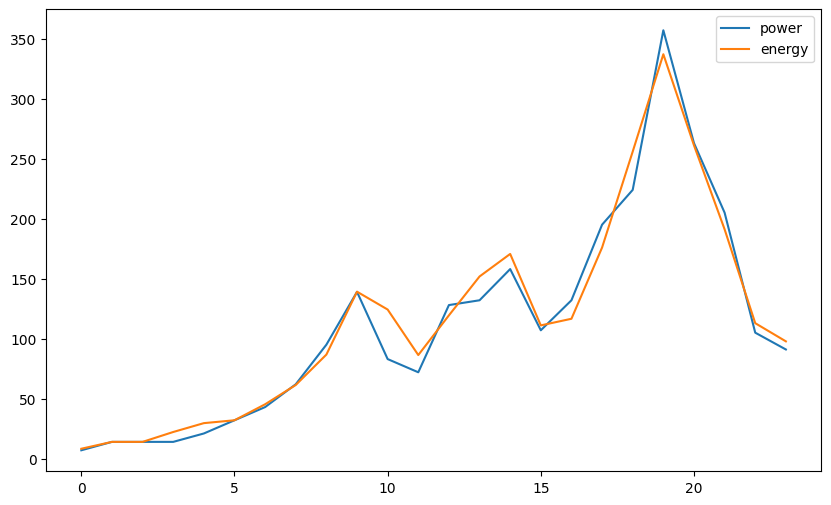

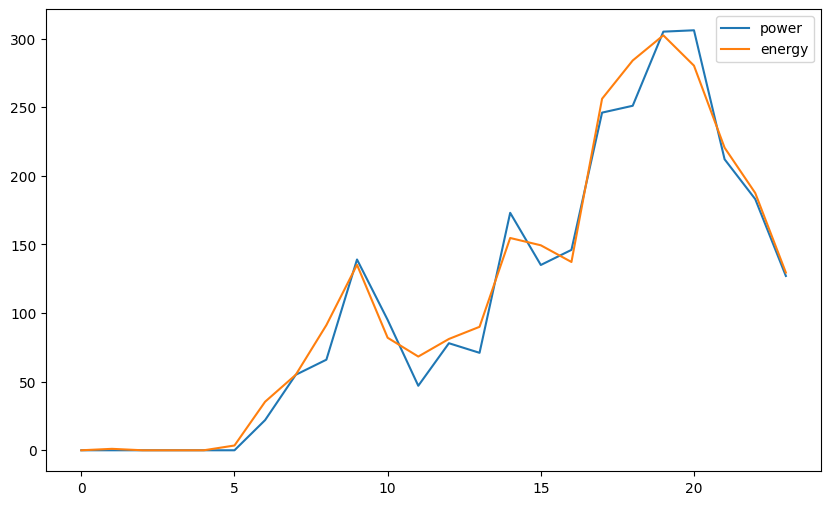

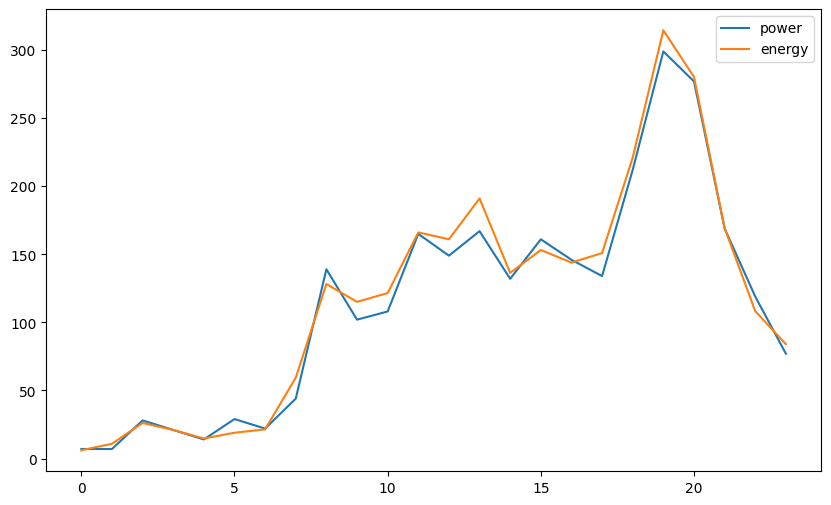

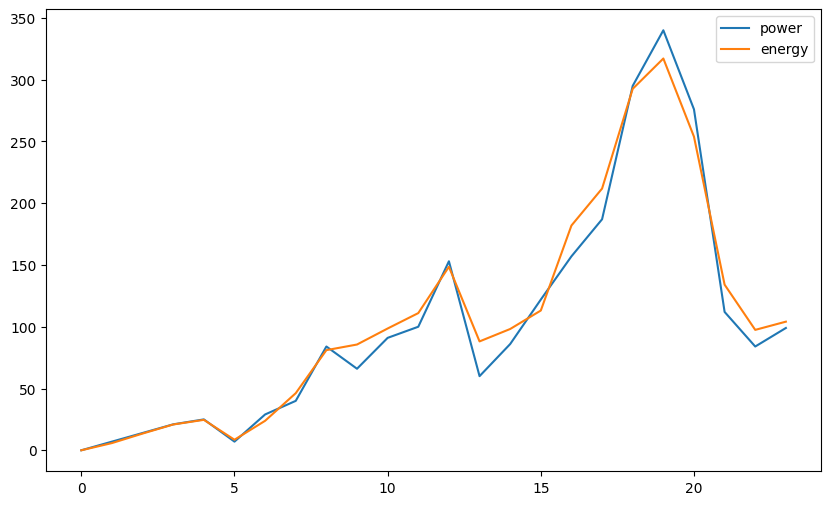

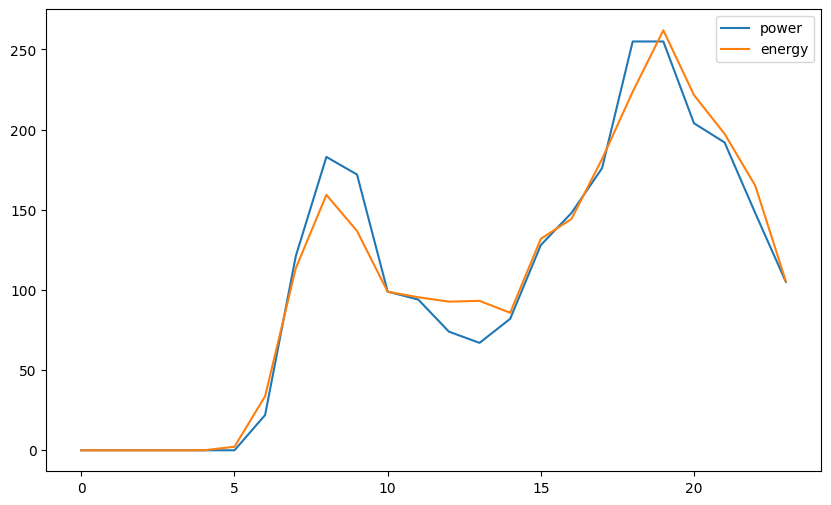

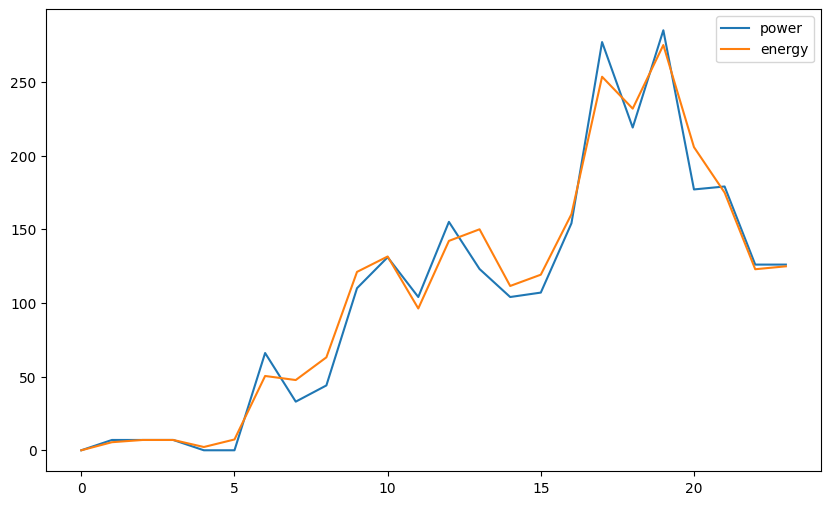

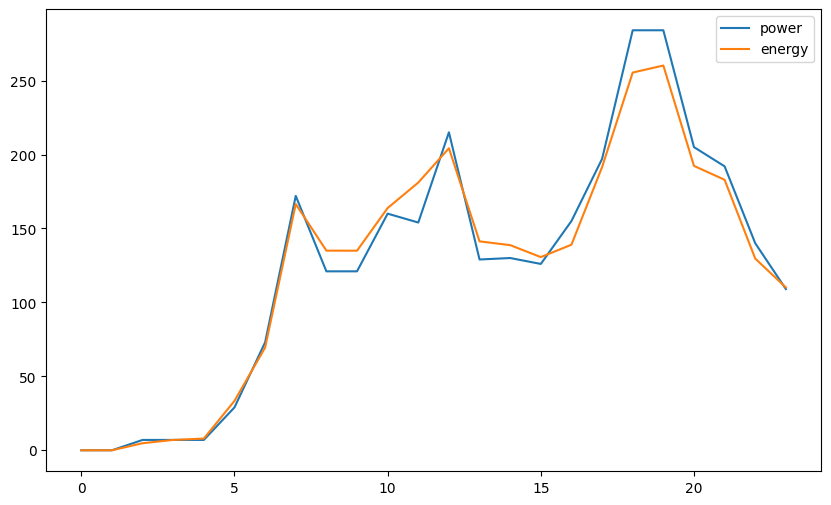

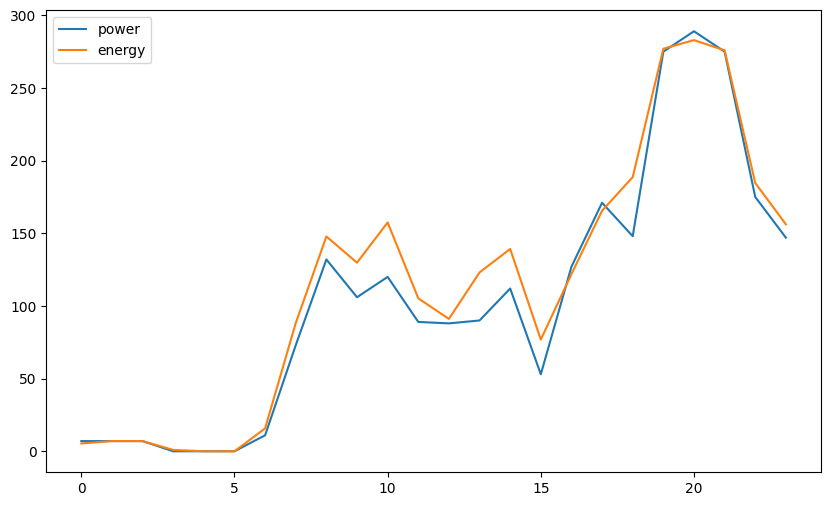

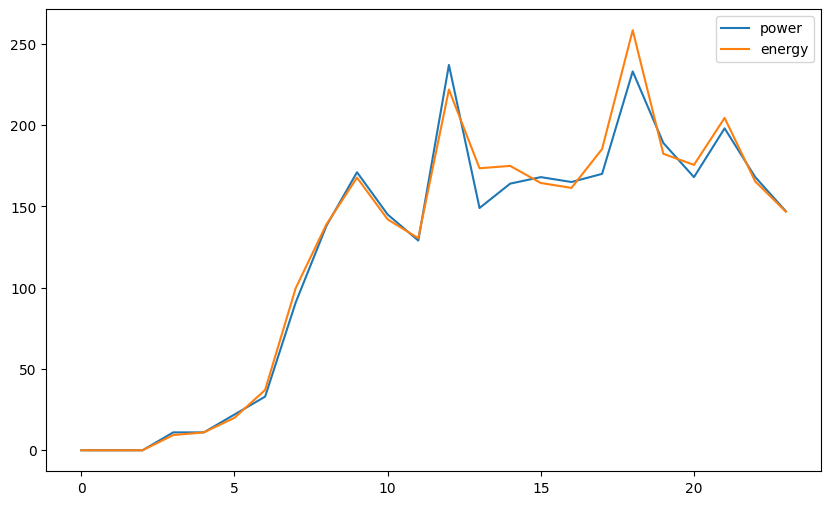

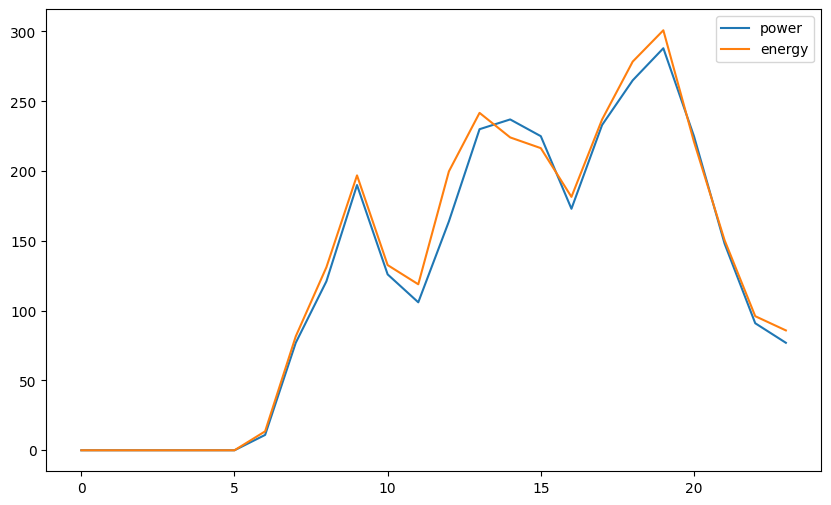

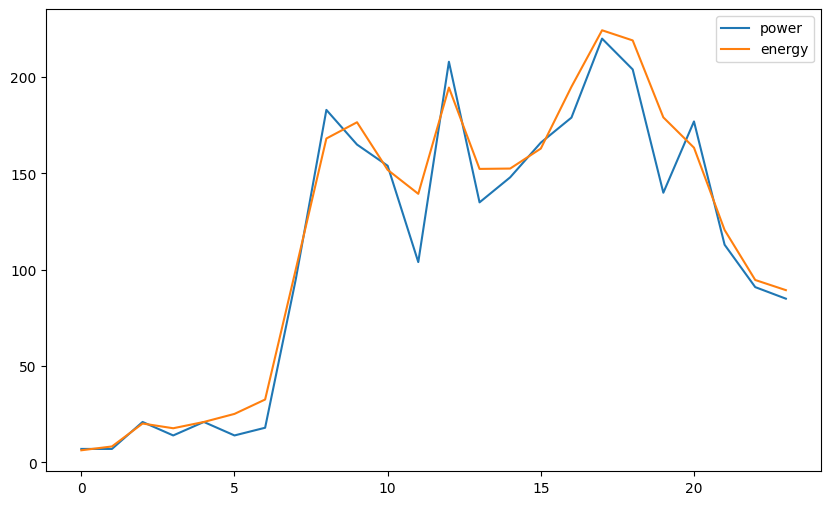

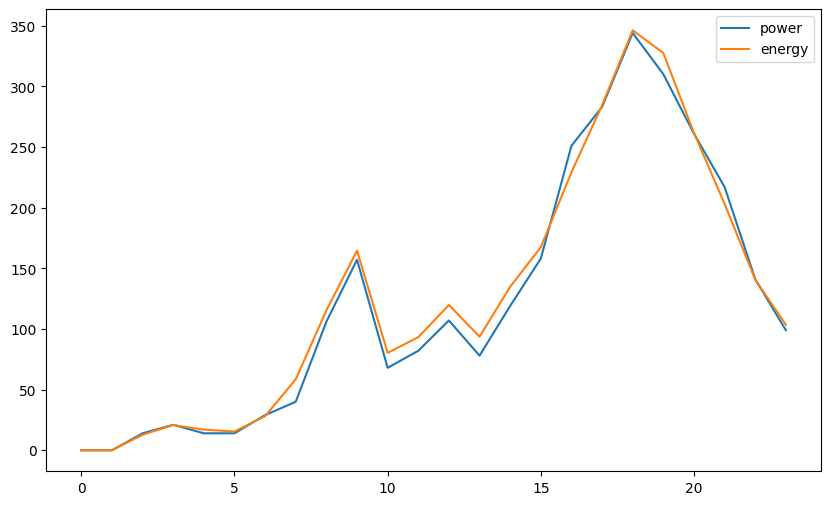

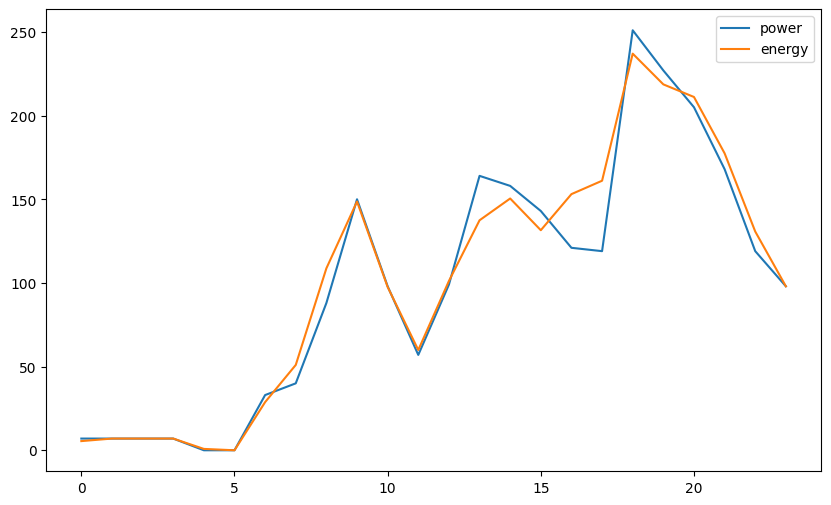

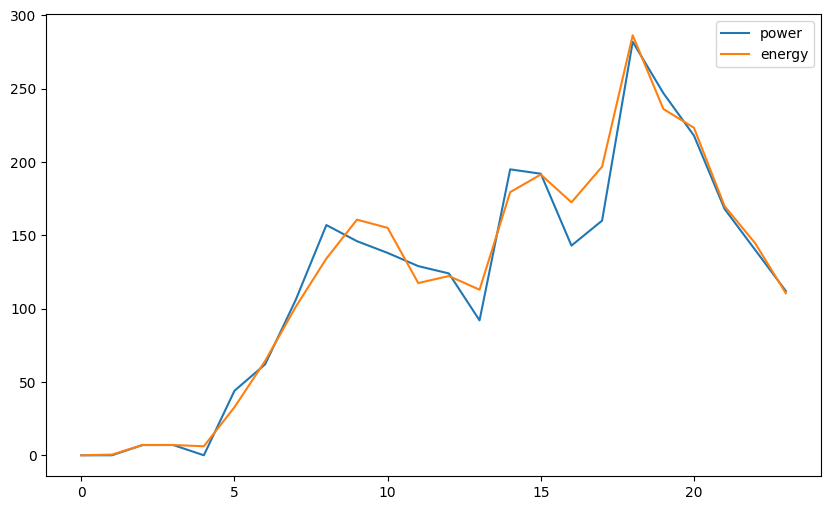

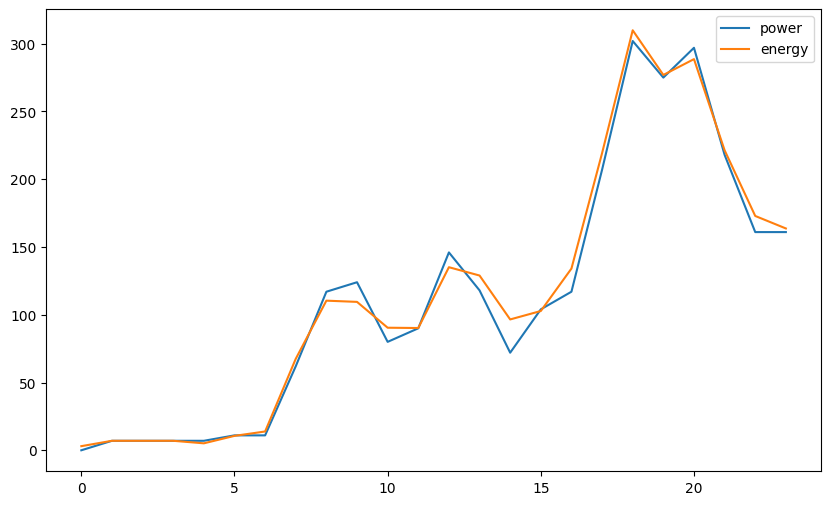

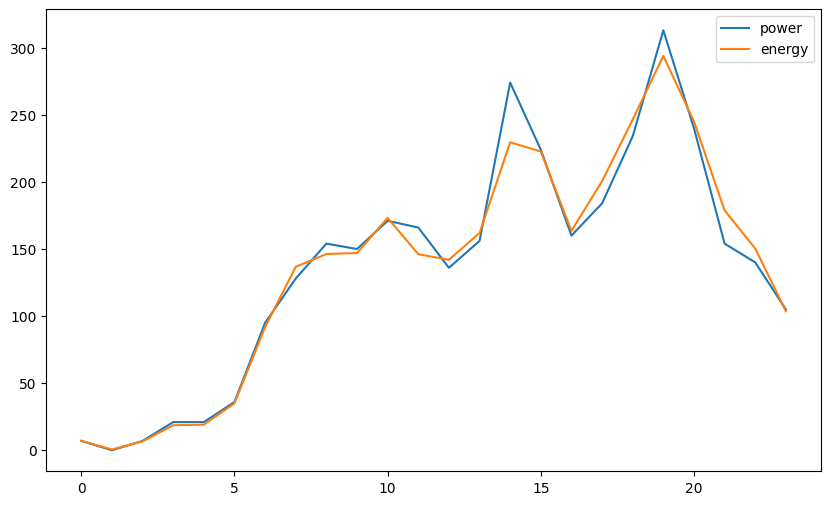

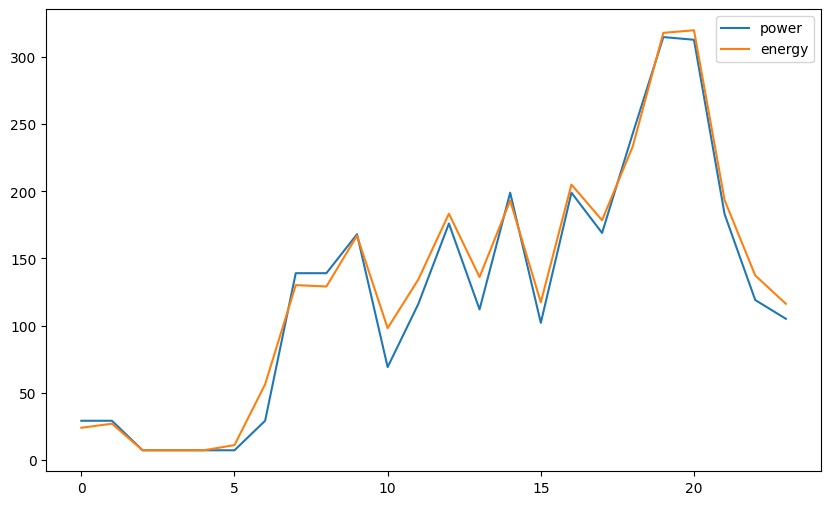

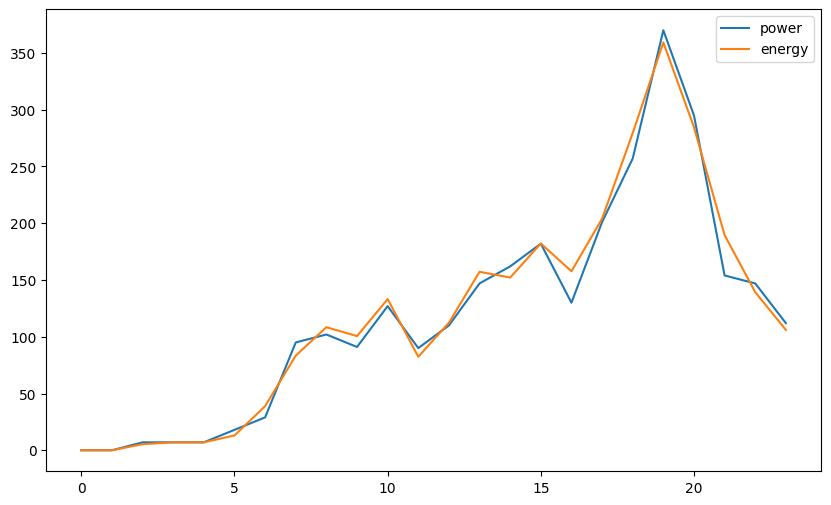

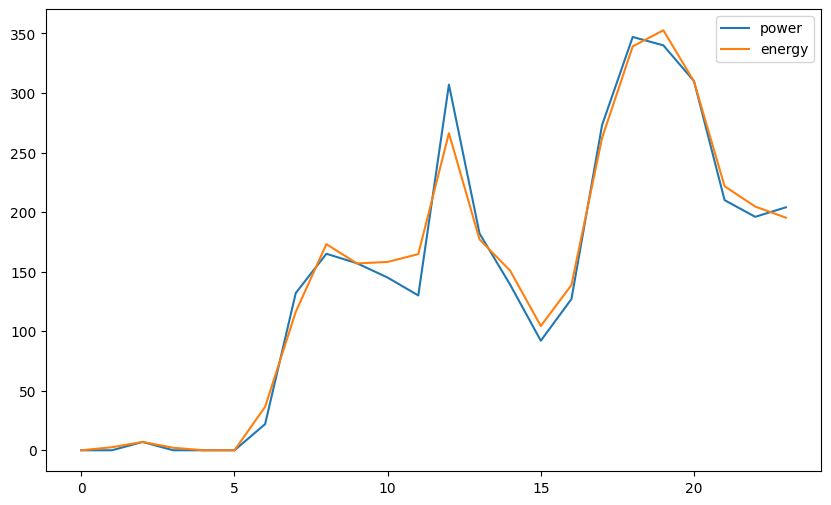

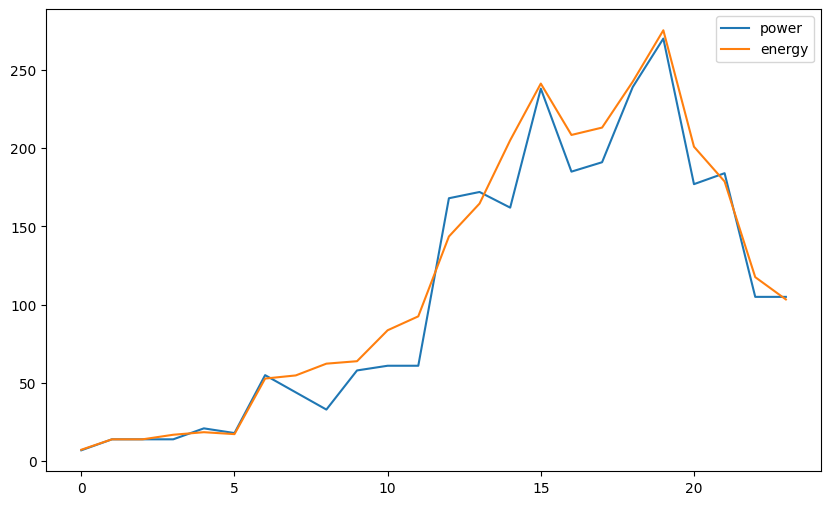

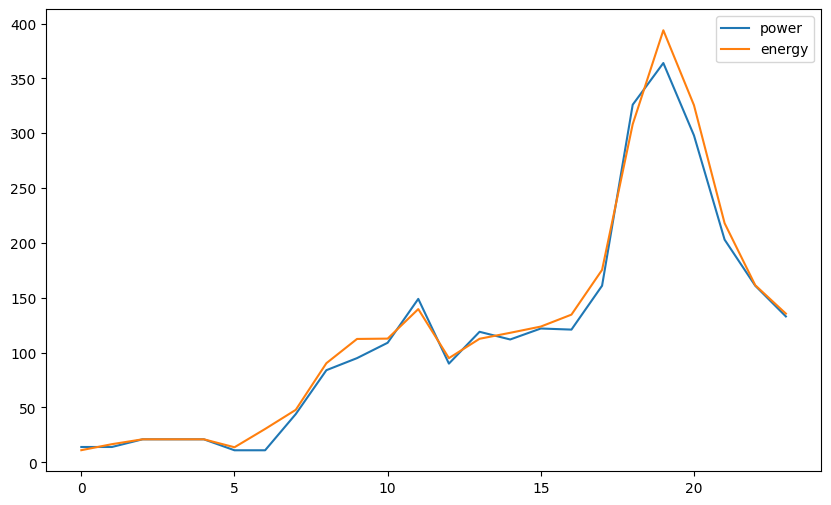

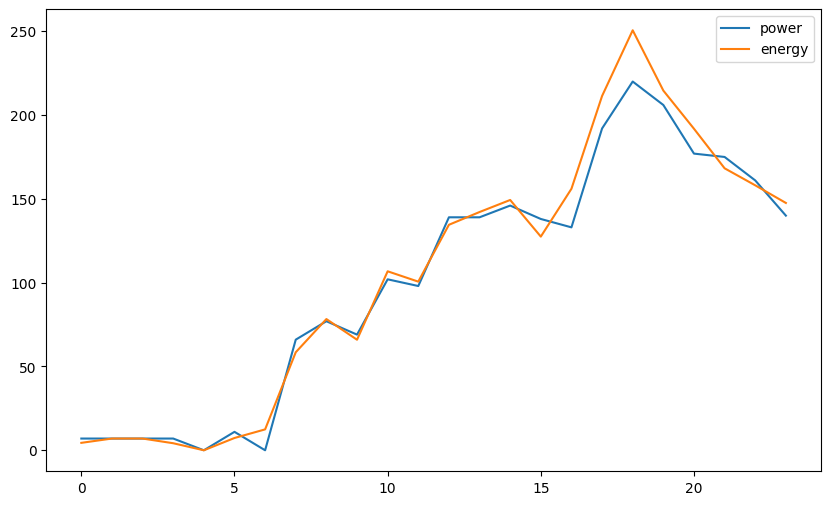

In [46]:
# Normalize the mobility aggregated charge power, calculate min, max, sum of power if there were EVs charging in the cluster then optimize this cluster's charging behavior to fit the curve
for i in range(8,num_groups):
    cluster = clustered[(clustered['group']==i+1) & (clustered['grid']==grid)]
    
    firsts = cluster.groupby('person').agg({
        'c': 'first',
        'ed_chg_time': 'first',
        'SoE_ac': 'first',
        'SoE_bc': 'first'
    }).reset_index() 
    condition = (firsts['c'] == True) & (firsts['ed_chg_time'] < day_start)
    firsts['start_SoE'] = firsts.apply(lambda x: x['SoE_ac'] if condition.loc[x.name] else x['SoE_bc'], axis=1)
    cluster['start_SoE'] = cluster['person'].map(firsts.set_index('person')['start_SoE'])


    emob_agg_e = [sum(x) for x in zip(*cluster['charge_energy_list'])] # energy in kWh
    emob_agg_p = [sum(x) for x in zip(*cluster['charge_power_list'])] # power in kW

    emob_max_p, emob_min_p,emob_tot_p = max(emob_agg_p), min(emob_agg_p), sum(emob_agg_p)
    print("Mobility data peak power:",emob_max_p,"Mobility data minimal power:",emob_min_p,"Mobility data total power:",emob_tot_p)

    emob_max_e, emob_min_e, emob_tot_e= max(emob_agg_e), min(emob_agg_e),sum(emob_agg_e)
    print("Mobility data peak energy:",emob_max_e,"Mobility data minimal energy:",emob_min_e,"Mobility data total energy:",emob_tot_e)

    if emob_max_p!=0:
        emob_agg_p_norm =  [p/emob_max_p for p in emob_agg_p]
        plt.figure(figsize=(10,6))
        plt.plot(emob_agg_p,label='power')
        plt.plot(emob_agg_e,label='energy')
        plt.legend()
        plt.savefig(f'{path}/369_9_cluster_{i}_agg_p_e.png')
        cluster.loc[:,'normalized_chg_power'] = cluster['chg rate']/emob_max_p
        normalized_tot_e = emob_tot_e/emob_max_p
        opt_res_code = opt_charge_profile(charge,discharge,net_normalized,cluster,emob_max_p,normalized_tot_e,date,i,path)

    else:
        index = list(cluster['event_index'])
        T = list(range(24))
        res_dict = {(e, t):0 for e in index for t in T} # Denormalize back to normal power value in kW
        # Convert the dictionary into a multi-index series to facilitate unstacking
        res = pd.Series(res_dict).unstack()
        # Save the restructured data to CSV
        res.to_csv(f'{path}/369_0_cluster_{i}.csv')

In [48]:
d_in = clustered[(clustered['grid']=='369_0')]
agg_e = [sum(x) for x in zip(*d_in['charge_energy_list'])] #total energy in kWh for the interested grid
agg_p = [sum(x) for x in zip(*d_in['charge_power_list'])] # power in kW
max_p,min_p,tot_p = max(agg_p), min(agg_p), sum(agg_p)
max_e, min_e,tot_e= max(agg_e), min(agg_e),sum(agg_e)
print(tot_e)

86284.21666666669


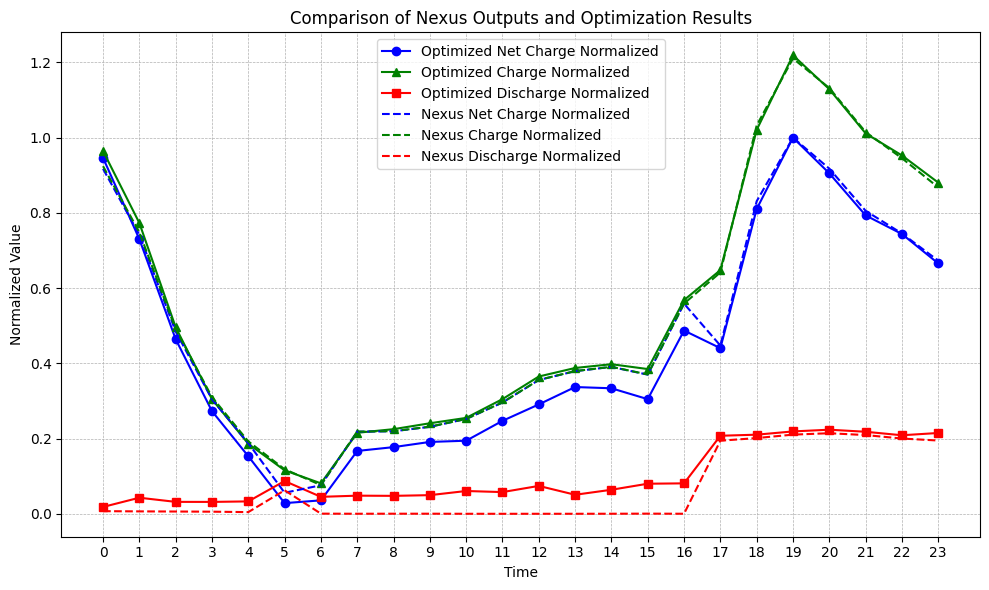

In [47]:
concat_charge = pd.DataFrame()
concat_discharge = pd.DataFrame()
concat_soe = pd.DataFrame()
for i in range(num_groups):
    charge_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_charge.csv')
    concat_charge = pd.concat([concat_charge,charge_i],axis=0)
    discharge_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_discharge.csv')
    concat_discharge = pd.concat([concat_discharge,discharge_i],axis=0)
    soe_i = pd.read_csv(f'{path}/{grid}_cluster_{i}_soe.csv')
    concat_soe = pd.concat([concat_soe,soe_i],axis=0)
    
concat_charge = concat_charge.rename(columns={'Unnamed: 0':'event_index'})
concat_discharge = concat_discharge.rename(columns={'Unnamed: 0':'event_index'})
concat_soe = concat_soe.rename(columns={'Unnamed: 0':'person'})

concat_res = concat_charge-concat_discharge
concat_res.loc[:,'event_index'] = concat_charge['event_index']
concat_res.set_index('event_index', inplace=True)

# Cast to 0 is power too low
for column in concat_res.columns:
    if column != 'event_index':
        # Apply the condition and replace values
        concat_res.loc[:, column] = concat_res[column].apply(lambda x: 0 if abs(x) < 0.01 else x)
        
concat_charge.to_csv(f'{path}/concat_charge_power_all.csv')
concat_discharge.to_csv(f'{path}/concat_dicharge_power_all.csv')
concat_res.to_csv(f'{path}/concat_net_power_all.csv')
concat_soe.to_csv(f'{path}/concat_soe_all.csv')

concat_sum = concat_res.sum().sum()
concat_max = concat_res.sum().max()
plt.figure(figsize=(10, 6))

# Optimized results with solid lines and markers
plt.plot(concat_res.sum()/concat_max, label='Optimized Net Charge Normalized', color='blue', linestyle='-', marker='o')
plt.plot(concat_charge.sum()[1:]/concat_max, label='Optimized Charge Normalized', color='green', linestyle='-', marker='^')
plt.plot(concat_discharge.sum()[1:]/concat_max, label='Optimized Discharge Normalized', color='red', linestyle='-', marker='s')

# Nexus outputs with dashed lines
plt.plot(net_normalized, label='Nexus Net Charge Normalized', color='blue', linestyle='--')
plt.plot(charge['normalized_profile'], label='Nexus Charge Normalized', color='green', linestyle='--')
plt.plot(discharge['normalized_profile'], label='Nexus Discharge Normalized', color='red', linestyle='--')

plt.title('Comparison of Nexus Outputs and Optimization Results')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f'{path}/optimized_norm_power_vs_nexus.png')
plt.show()


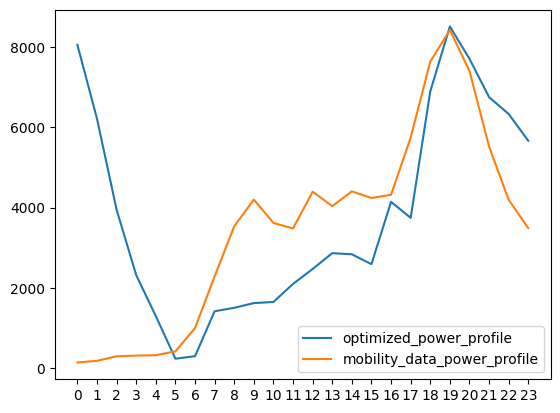

In [49]:
res_p = concat_res.sum()
plt.plot(res_p,label='optimized_power_profile')
plt.plot(agg_p, label='mobility_data_power_profile')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_power_profile.png')

In [50]:
concat_res = concat_res.sort_index()
time = pd.DataFrame(d['hourly_time_dict'].sort_index())
event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/1169159873.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  event_e = concat_res.apply(lambda row: [row[col]*time.at[row.name,'hourly_time_dict'][col]/60 for col in range(24)],axis=1)


In [51]:
e = pd.DataFrame(event_e.tolist())
e.set_index(concat_res.index,inplace=True)
res_e = pd.Series(e.sum(),name='agg_e')
res_e_sum = res_e.sum()

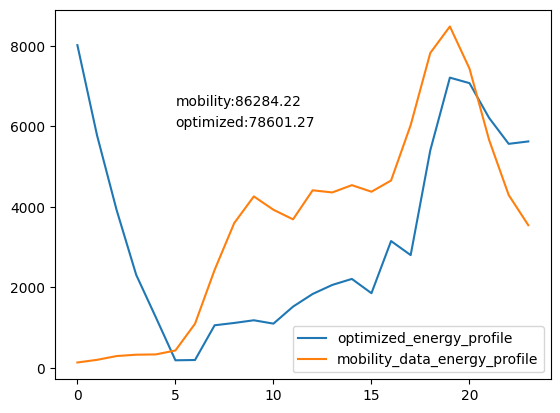

In [52]:
res_p = concat_res.sum()
# plt.plot(res_p,label='optimized_power_profile')
plt.plot(res_e,label='optimized_energy_profile')
plt.plot(agg_e,label='mobility_data_energy_profile')
plt.text(5,6500,f'mobility:{tot_e:.2f}')
plt.text(5,6000,f'optimized:{res_e_sum:.2f}')
plt.legend()
plt.savefig(f'{path}/optimized_vs_mobility_energy_profile.png')

In [53]:
res = pd.read_csv(f'{path}/concat_net_power_all.csv',index_col='event_index')
powerlist = res.apply(lambda row: row.tolist(), axis=1)
powerlist.sort_index()
soe_all = pd.read_csv(f"{path}/concat_soe_all.csv", index_col='person')
soe_end = soe_all['23']

In [54]:
d_in.sort_index()
d_in.loc[:,'optimized_power_list'] = powerlist
d_in.loc[:,'optimized_energy_list'] = d_in.apply(lambda row: [row['hourly_time_dict'][x]/60 * row['optimized_power_list'][x] for x in range(24)], axis=1)
d_in['process_list'] = d_in.apply(lambda row:get_timestamp_pair(row),axis=1)
d_in['day_end_soe'] = d_in['person'].map(soe_end)
d_in['unshifted_day_end_soe'] = d_in.groupby('person')['SoE_ac'].transform(lambda x: x.iloc[-1])
d_in['day_end_soe_shift'] = (d_in['day_end_soe']-d_in['unshifted_day_end_soe'])/d_in['unshifted_day_end_soe']
d_in['process_cnt'] = d_in['process_list'].apply(len)
d_in['shifted_process_cnt'] = d_in.groupby('person')['process_cnt'].transform(lambda x:x.sum())
d_in['unshifted_process_cnt'] = d_in.groupby('person')['c'].transform(lambda x: x.sum())
d_in['flex'] = d_in['optimized_power_list'] != d_in['charge_power_list']
d_in.to_pickle(f'{path}/grid_{grid}_{scenario_year}_{this_weekday}_1trip_res_postprocessed.pkl')
d_in

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/2121058901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_in.loc[:,'optimized_power_list'] = powerlist
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_26399/2121058901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_in.loc[:,'optimized_energy_list'] = d_in.apply(lambda row: [row['hourly_time_dict'][x]/60 * row['optimized_power_list'][x] for x in range(24)], axis=1)
/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipyker

,person,dep_time,trav_time,traveled_distance,start_activity_type,end_activity_type,start_x,start_y,end_x,end_y,arr_time,parking_time,TP1 consumption kWh,id_node,name_node,type_day,B,chg rate,SoE_bc,soe_if,c,SoE_ac,st_chg_time,ed_chg_time,grid,chg_time,arr_hour,dep_hour,arr_type_day,park_end_time,park_end_hour,park_end_day,next_trip_e,max_chg_e,real_chg_e,hourly_time_dict,soe_init,charge_time_list,charge_power_list,charge_energy_list,group,SoE_change,pre_ed_chg_time,pre_c,shifted_SoE_ac,shifted_SoE_bc,optimized_power_list,optimized_energy_list,process_list,day_end_soe,unshifted_day_end_soe,day_end_soe_shift,process_cnt,shifted_process_cnt,unshifted_process_cnt,flex
event_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
170,63620,2050-05-06 10:59:57,25.000000,30.753,work,leisure,2689194.0,1249241.0,2701360.0,1266068.0,2050-05-06 11:24:57.000000000,35.000000,9.569102,89.0,CH_Riet_220,Friday,120.0,22.0,94.04,NaN,False,94.04,2050-05-06 11:24:57.000000000,2050-05-06 11:24:57.000000000,369_0,0.000000,11,10,4,2050-05-06 11:59:57.000000000,11,6,9.236092,25.96,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 0, 0, 0,...","[94.04, 94.04, 94.04, 94.04, 94.04, 94.04, 94....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,0.00,NaT,False,94.04,94.04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{},94.04,94.04,1.511150e-16,0,0,0,False
193,75999,2050-05-06 07:54:19,90.383333,100.860,home,shop,2724123.0,1205943.0,2703640.0,1264933.0,2050-05-06 09:24:41.999999998,29.616667,30.983131,89.0,CH_Riet_220,Friday,120.0,22.0,89.02,NaN,False,89.02,2050-05-06 09:24:41.999999980,2050-05-06 09:24:41.999999980,369_0,0.000000,9,7,4,2050-05-06 09:54:19.000000018,9,6,55.504063,30.98,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0,...","[89.02, 89.02, 89.02, 89.02, 89.02, 89.02, 89....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,0.00,NaT,False,89.02,89.02,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{},89.02,89.02,0.000000e+00,0,0,0,False
313,94876,2050-05-06 13:32:23,66.400000,83.588,home,leisure,2724691.0,1220053.0,2697286.0,1268881.0,2050-05-06 14:38:47.000000000,113.600000,24.780334,89.0,CH_Riet_220,Friday,90.0,22.0,55.21,NaN,False,55.21,2050-05-06 14:38:47.000000000,2050-05-06 14:38:47.000000000,369_0,0.000000,14,13,4,2050-05-06 16:32:23.000000000,16,6,29.659693,34.79,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22,...","[55.21, 55.21, 55.21, 55.21, 55.21, 55.21, 55....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15,0.00,NaT,False,55.21,55.21,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{},55.21,55.21,0.000000e+00,0,0,0,False
388,109999,2050-05-06 07:44:30,90.750000,102.668,other,leisure,2729026.0,1220575.0,2701004.0,1270718.0,2050-05-06 09:15:15.000000000,163.300000,31.837159,89.0,CH_Riet_220,Friday,120.0,22.0,87.55,NaN,False,87.55,2050-05-06 09:15:15.000000000,2050-05-06 09:15:15.000000000,369_0,0.000000,9,7,4,2050-05-06 11:58:33.000000000,11,6,29.450024,32.45,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 60, 58, 0, 0, ...","[87.55, 87.55, 87.55, 87.55, 87.55, 87.55, 87....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17,0.00,NaT,False,87.55,87.55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{},87.55,87.55,0.000000e+00,0,0,0,False
438,119166,2050-05-06 05:17:52,84.816667,111.438,home,work,2671710.0,1204953.0,2698392.0,1265630.0,2050-05-06 06:42:41.000000002,755.183333,35.05

In [61]:
# Stat
# Participation rate
flex_dict = d_in.groupby('person')['flex'].transform('any')
print("Parking event count:", len(flex_dict))
print("Person/Vehicle count:", d_in['person'].nunique())
print("Flexibility participation rate by person:", float(flex_dict.sum()/len(flex_dict)))
print("Flexibility participation rate by parking event", float(d_in.flex.sum()/len(d_in)))

Parking event count: 35165
Person/Vehicle count: 17548
Flexibility participation rate by person: 0.669813735248116
Flexibility participation rate by parking event 0.3856675671832788


1.726535982670178 -1.0


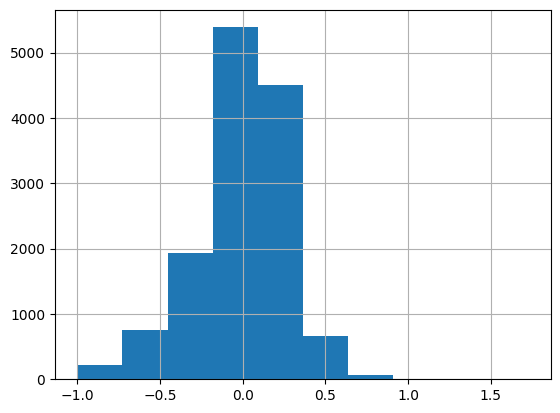

In [58]:
# Shifted Day End soe
flex_soe = d_in[d_in['flex']==True]
print(flex_soe['day_end_soe_shift'].max(), flex_soe['day_end_soe_shift'].min())
ax = flex_soe['day_end_soe_shift'].hist()

In [55]:
d_in[d_in['day_end_soe']<0][['person','dep_time','arr_time','st_chg_time','ed_chg_time','SoE_bc','SoE_ac','day_end_soe','unshifted_day_end_soe','SoE_change','optimized_energy_list']]

,person,dep_time,arr_time,st_chg_time,ed_chg_time,SoE_bc,SoE_ac,day_end_soe,unshifted_day_end_soe,SoE_change,optimized_energy_list
event_index,,,,,,,,,,,
724943,8122081,2050-05-05 20:44:28,2050-05-05 21:13:05.999999998,2050-05-05 21:13:05.999999980,2050-05-06 01:52:36.857142820,37.39,70.0,-2.477185e-15,70.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
724946,8122081,2050-05-06 20:44:28,2050-05-06 21:13:05.999999998,2050-05-06 21:13:05.999999980,2050-05-07 00:19:00.857142820,48.31,70.0,-2.477185e-15,70.0,21.69,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
